In [208]:
homedir <- '/Users/chenlingantelope/ResearchProjects/scRNA_simulation/'
setwd(homedir)

library('devtools')
library("DESeq2")
library('fossil')

load('allsim.20170706.robj')
load('match_params.robj')
load_all('SCsimR')
options(repr.plot.width=5, repr.plot.height=4)

Loading SCsim


# Simulation: an example run 
We will simulate a dataset using the SimulateDataset function using all its default parameters. 
The only mendatory inputs are 
* **phyla**: the tree structure of cell populations. It is generated using the ape package, branch lengths and relationships manually specified in function Phyla5()
* **evf_type**: There are two evf_type options, *Discrete* and *Continuous*. They affect how evf values are sampled from the tree structure. 
* **gene_effect_prob**: this affects the sparcity of the gene_effect matrix. 

In [21]:
ncells <- 1000
ngenes <- 2000
nbatch <- 3
nevf <-10
phyla <- Phyla5()
result=SimulateDataset(ncells,ngenes,nbatch,nevf,phyla=phyla,evf_type='Discrete',gene_effect_prob=0.1,Sigma=0.3)

#### Output 1
The first element of the output result are 3 count matrices of dimension $N_{genes} \times N_{cells}$. The first one is the true counts, second is the dropped counts, and third is the biased counts. We can visualize the matrices using the function PlotCountHeatmap. 

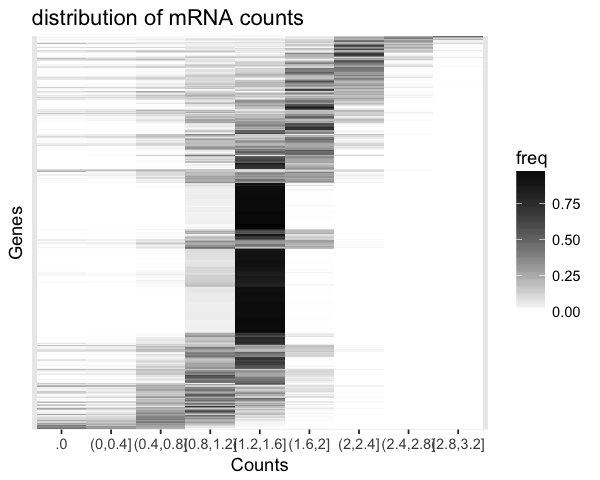

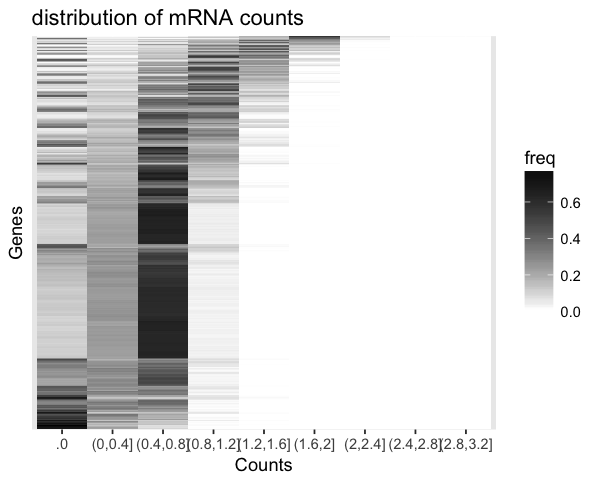

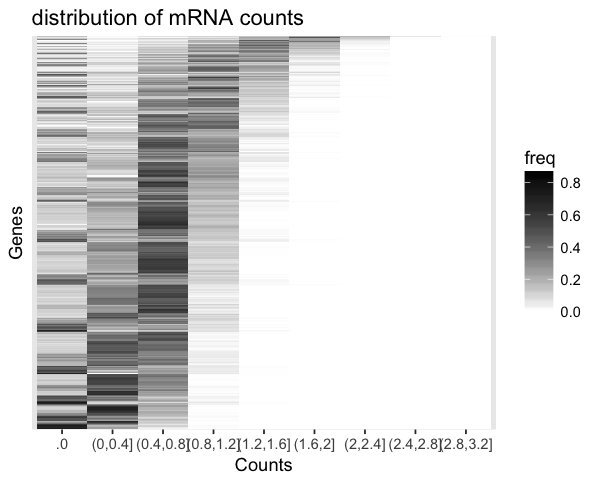

In [22]:
PlotCountHeatmap(LogDist(result[[1]][[1]],seq(0,3.2,0.4)),rowMeans(result[[1]][[1]]))
PlotCountHeatmap(LogDist(result[[1]][[2]],seq(0,3.2,0.4)),rowMeans(result[[1]][[2]]))
PlotCountHeatmap(LogDist(result[[1]][[3]],seq(0,3.2,0.4)),rowMeans(result[[1]][[3]]))

#### Output 2
The second element of the output result is a matrix that specifies the cell level meta data, including 
* the population identity of each cell
* the batch the cell is 'sequenced' in
* the drop out rate for that cell
* its evf vector ($\times N_{evf}$)

In [8]:
head(result[[2]])

pop,batch,alpha,evfs.1,evfs.2,evfs.3,evfs.4,evfs.5,evfs.6,evfs.7,evfs.8,evfs.9,evfs.10
1,3,0.11879985,-0.4189108,1.892205,-0.3079467,0.3395541,-0.47545417,-0.5979358,-0.7581988,-1.2421512,1.5503836,1.461484
1,2,0.08909574,0.3201263,1.328370,-0.1537362,0.9919917,-0.20842572,-2.0254307,-0.1272319,-0.6568883,0.3138070,2.137547
1,3,0.10382291,0.8192407,1.696855,-0.3575858,1.1775389,-0.02537395,-1.4033879,-1.5478892,0.2842274,-0.4968284,2.117941
1,3,0.10347622,0.5478717,1.229276,-0.5182931,0.1493809,-1.00937588,-1.1803983,-0.6956980,-0.1321212,0.3188676,1.759788
1,3,0.11652262,1.2429714,1.069070,-0.3845510,1.9653763,-0.58874575,-1.7140957,-0.3505089,-0.7163237,1.3825789,1.328374
1,2,0.09477308,0.1815665,2.368294,-0.5203292,1.2471649,-0.42993940,-0.8034854,-0.6882467,-0.7343371,1.4801564,1.777852


#### Output 3
The third element of the output result is the gene level metadata, including
* gene effect of the kinetic parameter $k_{on}$, $k_{off}$ and $s$ ($\times 3\times N_{evf}$)
* GC content bins
* the effect of GC bias
* length bins
* the effect of length bias
* batch effect ($\times N_{batch}$)

In [9]:
head(result[[3]])

kon_effect.1,kon_effect.2,kon_effect.3,kon_effect.4,kon_effect.5,kon_effect.6,kon_effect.7,kon_effect.8,kon_effect.9,kon_effect.10,⋯,s_effect.8,s_effect.9,s_effect.10,gcbias.rand_gene,gcbias.bias,lenbias.rand_gene,lenbias.bias,batch.1,batch.2,batch.3
0,0,0.000000,0,0.0000000,0,0,0.00000000,0.0000000,0.0000000,⋯,0,0.0000000,0,9,1.035,8,0.75,1.1571936,1.1747836,0.6054657
0,0,1.219213,0,0.5353241,0,0,0.00000000,0.0000000,0.0000000,⋯,0,0.0000000,0,8,1.025,5,1.05,1.8428479,1.0414622,1.7370878
0,0,0.000000,0,0.0000000,0,0,0.00000000,0.0000000,0.0000000,⋯,0,0.0000000,0,8,1.025,3,1.25,0.2782538,1.0937828,1.1598503
0,0,0.000000,0,0.0000000,0,0,0.00000000,0.7081295,0.0000000,⋯,0,0.0000000,0,5,0.995,7,0.85,0.4695522,0.9332005,1.0047508
0,0,0.000000,0,0.0000000,0,0,0.00000000,-0.4864276,0.0000000,⋯,0,0.1132505,0,7,1.015,4,1.15,0.8385602,1.0051619,1.1380494
0,0,0.000000,0,0.0000000,0,0,-0.04448672,0.0000000,0.5493258,⋯,0,0.0000000,0,4,0.985,1,1.45,0.9090658,1.9811224,1.1878613


# Differential Expression (DE)
In this section we use SimulateDataset to test the effect of different parameters on the accuracy of DE detection. 

**Note** The reduce the runtime for this tutorial we only simulate a small number of cells and genes, but users can easily tweak the parameters here to test the effect of their parameter of interest with more reasonable number of cells and genes

In [184]:
ncells <- 100
ngenes <- 200
nbatch <- 3
nevf <-10
phyla <- Phyla5()
start.time=proc.time()
result=SimulateDataset(ncells,ngenes,nbatch,nevf,phyla=phyla,evf_type='Discrete',gene_effect_prob=0.3)
proc.time()-start.time

   user  system elapsed 
 10.116   0.421  10.607 

### Find the gold standard DE genes
We identify genes that should be differentially expressed by how much their kinetic parameters are affected by their population identity. 
For each parameter $k_{on}$,$k_{off}$ and $s$ we find a list of genes where they are upregulated and a list of genes where they are down regulated. 

In [87]:
evfs <- result[[2]][,grep('evf',colnames(result[[2]]))]
pop1 <- result[[2]]$pop==1
de_true <- lapply(c('kon_effect','koff_effect','s_effect'),function(X){
    effect <- result[[3]][,grep(X,colnames(result[[3]]))]
    value <- t(as.matrix(evfs) %*% t(as.matrix(effect)))
    diff <- lapply(c(1:ngenes),function(gid){
        diff <- t.test(value[gid,pop1],value[gid,!pop1])
        c(diff$p.value,diff$conf.int)
    })
    diff <- do.call(rbind,diff)
    pos <- c(1:ngenes)[diff[,1]<0.05 & diff[,2] > 0.1]
    neg <- c(1:ngenes)[diff[,1]<0.05 & diff[,3] < (-0.1)]
    pos <- pos[!is.na(pos)];neg <- neg[!is.na(neg)]
    return(list(pos,neg))
})

### Calculate log fold change in true counts
We compare how the true log fold change is related to the changes in the kinetic parameters. Changes in $s$ is the most related to the log fold change. Changes in $k_{on}$ and $k_{off}$ also affects the log fold change although not as significantly.

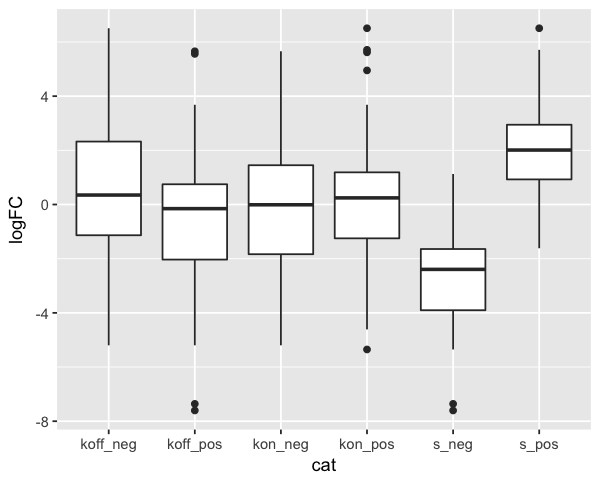

In [127]:
logFC <- log2(rowMeans(result[[1]][[1]][,pop1])/ rowMeans(result[[1]][[1]][,!pop1]))
categories <- c('kon_pos','kon_neg','koff_pos','koff_neg','s_pos','s_neg')
param_FC <- lapply(do.call(c,de_true),function(X){logFC[X]})
param_FC <- lapply(c(1:6),function(i){
    X<-param_FC[[i]]
    cbind(X,rep(categories[i],length(X)))
})
param_FC <- do.call(rbind,param_FC)
param_FC <- data.frame(logFC =as.numeric(param_FC[,1]),cat=factor(param_FC[,2]))
ggplot(param_FC,aes(cat,logFC)) + geom_boxplot()

### Find DE genes by other published methods
* DEseq

In [128]:
colnames(result[[1]][[3]]) <- paste0("cell", 1:length(result[[1]][[3]][1,]))
rownames(result[[1]][[3]]) <- paste0("gene", 1:length(result[[1]][[3]][,1]))
coldata <- data.frame(pop=paste0("pop", result[[2]]$pop==1))
rownames(coldata) <- colnames(result[[1]][[3]])

dds <- DESeqDataSetFromMatrix(countData = round(result[[1]][[3]])+1,colData = coldata, design= ~ pop)
dds <- DESeq(dds)
rnms <- resultsNames(dds)
res <- results(dds) # choose contrast?

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


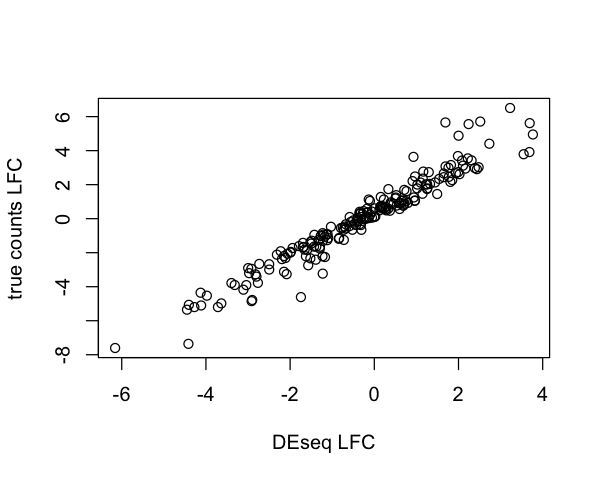

In [129]:
plot(res$log2FoldChange,logFC,xlab='DEseq LFC',ylab='true counts LFC')

In [130]:
DEseq_pos <- c(1:ngenes)[res$pvalue<0.05 & res$log2FoldChange>0]
DEseq_neg <- c(1:ngenes)[res$pvalue<0.05 & res$log2FoldChange<0]
overlaps <- do.call(rbind,
    lapply(do.call(c,de_true),function(X){
        c(length(intersect(X,DEseq_neg))/length(X),length(intersect(X,DEseq_pos))/length(X))
    })
)
rownames(overlaps) <- categories
colnames(overlaps) <- c('DE_pos','DE_neg')
overlaps

,DE_pos,DE_neg
kon_pos,0.37647059,0.2470588
kon_neg,0.42465753,0.3150685
koff_pos,0.48780488,0.2439024
koff_neg,0.33333333,0.3733333
s_pos,0.02469136,0.7407407
s_neg,0.88333333,0.0000000


### Obtaining the above results for a gradient of $\alpha$, conditional on the values of $\beta$

In [187]:
dataset <- lapply(seq(0.01,0.15,0.02),function(x){
    beta_DE_benchmark <- lapply(seq(0.5,1,0.1),function(y){
        result=SimulateDataset(alpha=x,beta=y,ncells,ngenes,nbatch,nevf,phyla=phyla,evf_type='Discrete',gene_effect_prob=0.3)
        return(list(x,y,result))
    })
})

In [188]:
DE_benchmark <- lapply(dataset, function(X){
    lapply(X,function(Y){
        DE_benchmark <- suppressMessages(DEseq_test(Y[[3]]))
        return(list(Y[[1]],Y[[2]],DE_benchmark))
    })
})

In [189]:
DE_benchmark <- do.call(c,DE_benchmark)
params <- do.call(rbind,lapply(DE_benchmark,function(X){c(X[[1]],X[[2]])}))
corr <- do.call(c,lapply(DE_benchmark,function(X){
    X <- X[[3]]
    notna <- (!is.na(X[[1]]) & !is.na(X[[2]])) & is.finite(X[[1]]) & is.finite(X[[2]])
    cor(X[[1]][notna],X[[2]][notna])
}))
acc <- do.call(c,lapply(DE_benchmark,function(X){X <- X[[3]];X[[4]][5,2]}))

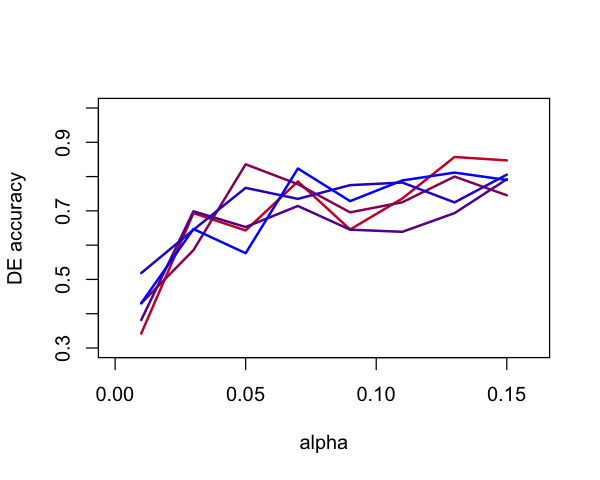

In [199]:
plot(x=0,y=0,xlim=c(0,0.16),ylim=c(0.3,1),pch='.',xlab='alpha',ylab='DE accuracy',cex=5)
colfunc <- colorRampPalette(c("red", "blue"))
col <- colfunc(length(unique(params[,2])))
coli <- 1
for (bimod in unique(params[,2])){
	coli <- coli+1
    exp <- (params[,2]==bimod)
    x <-params[exp,1]
    y <- acc[exp]
    points(x=x,y=y,type='l',col=col[coli],lwd=2)
}

# Clustering Cell Populations 
In this section we use SimulateDataset to test the effect of different parameters on the accuracy of clustering algorithms

**Note** We will be reusing the datasets *result* and *dataset* simulated in section 1 and 2, respectively

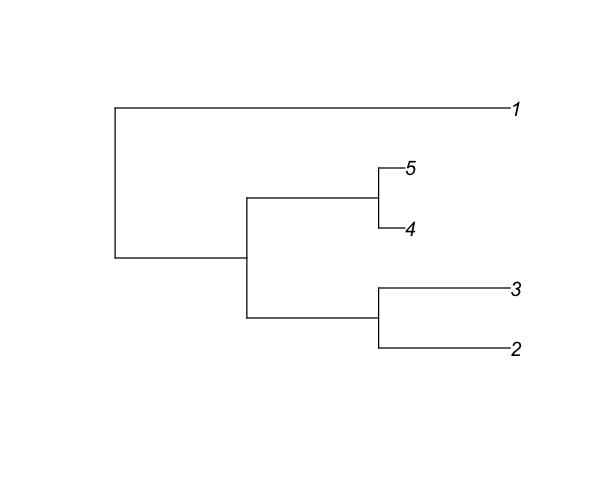

In [222]:
plot(phyla)

[1] 0.8317172 0.5159279

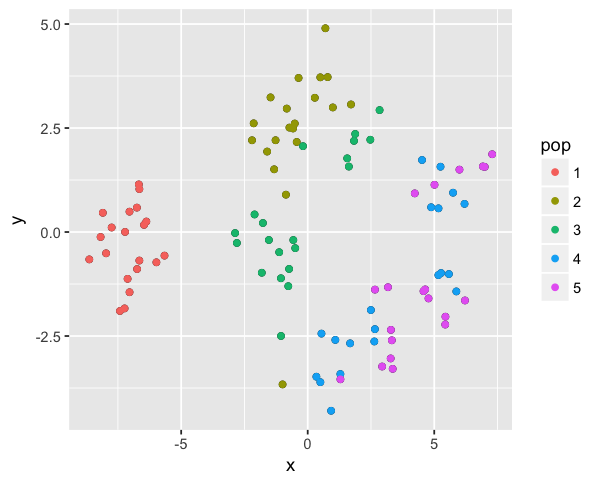

In [229]:
tsne <- PlotTsne(meta=result[[2]],data=result[[1]][[3]],label='pop',plotname='')
estimated <- as.numeric(kmeans(tsne[[1]][,c(6,7)],5)$cluster)
true <- as.numeric(tsne[[1]]$pop)
ri_tsne <- c(rand.index(true,estimated),adj.rand.index(true,estimated))
tsne[[2]]
ri_tsne

[1] 0.8315152 0.5169036

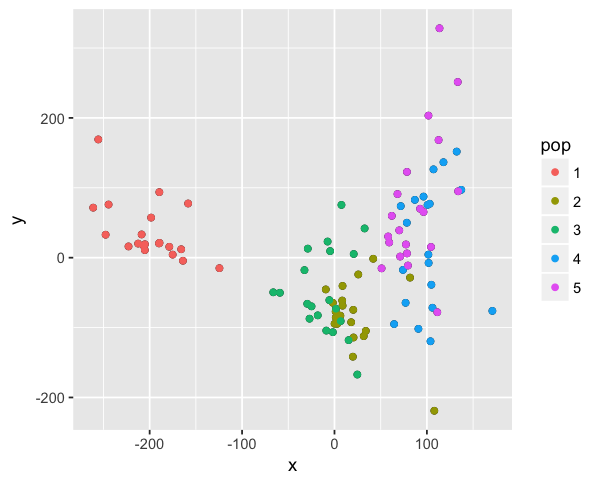

In [232]:
pca <- PlotPCA(meta=result[[2]],data=result[[1]][[3]],label='pop',plotname='')
estimated <- as.numeric(kmeans(pca[[1]][,c(6,7)],5)$cluster)
true <- as.numeric(pca[[1]]$pop)
ri_pca <- c(rand.index(true,estimated),adj.rand.index(true,estimated))
pca[[2]]
ri_pca

In [255]:
clustering_perf <- lapply(dataset, function(X){
    lapply(X,function(Y){
        result <- Y[[3]]
        tsne <- PlotTsne(meta=result[[2]],data=result[[1]][[3]],label='pop',plotname='')
        estimated <- as.numeric(kmeans(tsne[[1]][,c(6,7)],5)$cluster)
        true <- as.numeric(tsne[[1]]$pop)
        ri_tsne <- c(rand.index(true,estimated),adj.rand.index(true,estimated))
        pca <- PlotPCA(meta=result[[2]],data=result[[1]][[3]],label='pop',plotname='')
        estimated <- as.numeric(kmeans(pca[[1]][,c(6,7)],5)$cluster)
        true <- as.numeric(pca[[1]]$pop)
        ri_pca <- c(rand.index(true,estimated),adj.rand.index(true,estimated))
        return(c(Y[[1]],Y[[2]],ri_tsne,ri_pca))
    })
})
clustering_perf=do.call(rbind,do.call(rbind,clustering_perf))
colnames(clustering_perf)=c('alpha','beta','tsne_RI','tsne_adjustedRI','pca_RI','pca_adjusted_RI')

In [256]:
clustering_perf[clustering_perf[,2]==0.5,]

alpha,beta,tsne_RI,tsne_adjustedRI,pca_RI,pca_adjusted_RI
0.01,0.5,0.8488407,0.5384714,0.8488407,0.5384714
0.03,0.5,0.9117172,0.7223937,0.8759596,0.6311753
0.05,0.5,0.7731313,0.2849296,0.7517172,0.2389331
0.07,0.5,0.8606061,0.5604700,0.8606061,0.5604700
0.09,0.5,0.8266667,0.4979847,0.8525253,0.5268182
0.11,0.5,0.8381818,0.4847067,0.8325253,0.4729613
0.13,0.5,0.7454545,0.2470301,0.7919192,0.3490002
0.15,0.5,0.7258586,0.1987989,0.7258586,0.1987989


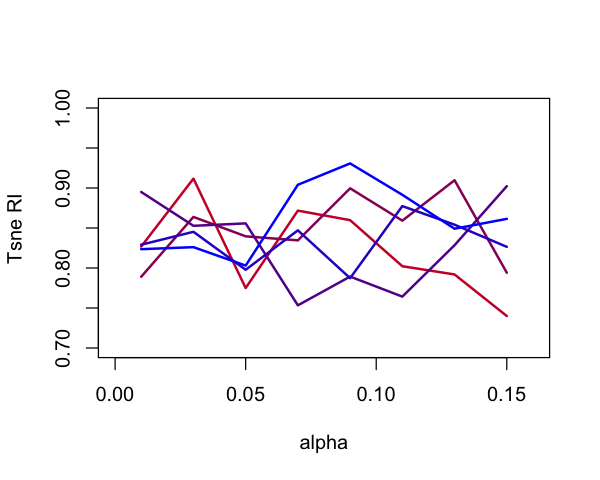

In [254]:
plot(x=0,y=0,xlim=c(0,0.16),ylim=c(0.7,1),pch='.',xlab='alpha',ylab='Tsne RI',cex=5)
colfunc <- colorRampPalette(c("red", "blue"))
col <- colfunc(length(unique(clustering_perf[,2])))
coli <- 1
for (bimod in unique(clustering_perf[,2])){
	coli <- coli+1
    exp <- (clustering_perf[,2]==bimod)
    x <-clustering_perf[exp,1]
    y <- clustering_perf[exp,3]
    points(x=x,y=y,type='l',col=col[coli],lwd=2)
}

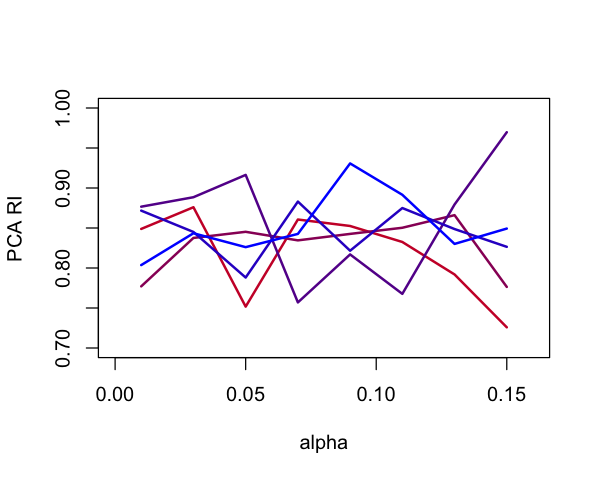

In [258]:
plot(x=0,y=0,xlim=c(0,0.16),ylim=c(0.7,1),pch='.',xlab='alpha',ylab='PCA RI',cex=5)
colfunc <- colorRampPalette(c("red", "blue"))
col <- colfunc(length(unique(clustering_perf[,2])))
coli <- 1
for (bimod in unique(clustering_perf[,2])){
	coli <- coli+1
    exp <- (clustering_perf[,2]==bimod)
    x <-clustering_perf[exp,1]
    y <- clustering_perf[exp,5]
    points(x=x,y=y,type='l',col=col[coli],lwd=2)
}

# Simulating continuous variation in EVF

In [ ]:
ncells <- 1000
ngenes <- 2000
nbatch <- 3
nevf <-10
phyla <- Phyla5()
source('ContinuousTree.R')
continuous_sim=SimulateDataset(ncells,ngenes,nbatch,nevf,phyla=phyla,evf_type='Continuous',gene_effect_prob=0.1,Sigma=0.3)